In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load processed data
df = pd.read_csv(r'C:\Users\admin\Desktop\data\raw\processed\processed_reviews.csv')
print(f"📊 Loaded {len(df)} processed reviews")

📊 Loaded 50000 processed reviews


In [2]:
# Prepare features and labels
X = df['processed_review']
y = df['sentiment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

print(f"📈 Training set size: {len(X_train)}")
print(f"📉 Test set size: {len(X_test)}")

# Feature extraction with TF-IDF
print("\n🔄 Creating TF-IDF features...")
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2,max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"✅ Feature matrix shape: {X_train_tfidf.shape}")
print(f"📝 Feature names sample: {tfidf.get_feature_names_out()[:10]}")

📈 Training set size: 40000
📉 Test set size: 10000

🔄 Creating TF-IDF features...
✅ Feature matrix shape: (40000, 3000)
📝 Feature names sample: ['abandoned' 'ability' 'able' 'absolute' 'absolutely' 'absurd' 'abuse'
 'academy' 'academy award' 'accent']


In [3]:
all_results = []
trained_models = {}

In [4]:
start = time.time()
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred = log_reg.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print(f"⏱ Logistic Regression training took {train_time:.2f} sec")
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Cross-validation on training set
cv_scores = cross_val_score(log_reg, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"📊 CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


# store results
all_results.append({
    "Model": "Logistic Regression",
    "Test Accuracy": round(acc, 4),
    "CV Mean": round(cv_scores.mean(), 4),
    "CV Std": round(cv_scores.std(), 4),
    "Train Time (s)": round(train_time, 2)
})

# store trained models
trained_models["Logistic Regression"] = log_reg

⏱ Logistic Regression training took 0.20 sec
🎯 Accuracy: 0.8836
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

📊 CV Mean: 0.8797 (±0.0049)


In [5]:
start = time.time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred = nb.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print(f"⏱ Naive Bayes training took {train_time:.2f} sec")
print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(nb, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"📊 CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# store results
all_results.append({
    "Model": "Naive Bayes",
    "Test Accuracy": round(acc, 4),
    "CV Mean": round(cv_scores.mean(), 4),
    "CV Std": round(cv_scores.std(), 4),
    "Train Time (s)": round(train_time, 2)
})

# store trained models
trained_models["Naive Bayes"] = nb


⏱ Naive Bayes training took 0.05 sec
🎯 Test Accuracy: 0.8513
              precision    recall  f1-score   support

    negative       0.86      0.83      0.85      5000
    positive       0.84      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

📊 CV Mean: 0.8499 (±0.0032)


In [6]:
start = time.time()
rf = RandomForestClassifier(
    n_estimators=200, max_depth=None, n_jobs=-1,
    random_state=42, verbose=1
)
rf.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred = rf.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
print(f"⏱ Random Forest training took {train_time/60:.2f} min")
print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(rf, X_train_tfidf, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"📊 CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

# store results
all_results.append({
    "Model": "Random Forest",
    "Test Accuracy": round(acc, 4),
    "CV Mean": round(cv_scores.mean(), 4),
    "CV Std": round(cv_scores.std(), 4),
    "Train Time (s)": round(train_time, 2)
})

# store trained models
trained_models["Random Forest"] = rf



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   21.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 200 out of 200 | elapsed:    0.0s finished


⏱ Random Forest training took 0.36 min
🎯 Test Accuracy: 0.8497
              precision    recall  f1-score   support

    negative       0.85      0.85      0.85      5000
    positive       0.85      0.85      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

📊 CV Mean: 0.8451 (±0.0025)


In [7]:
start = time.time()
svm = CalibratedClassifierCV(
    estimator=LinearSVC(random_state=42, max_iter=3000),
    cv=5,
    n_jobs=-1
)
svm.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred = svm.predict(X_test_tfidf)
print(f"⏱ Linear SVM training took {train_time/60:.2f} min")
print("🎯 Test Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cv_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=3, scoring='accuracy', n_jobs=-1)
print(f"📊 CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


# store results
all_results.append({
    "Model": "Linear SVM",
    "Test Accuracy": round(acc, 4),
    "CV Mean": round(cv_scores.mean(), 4),
    "CV Std": round(cv_scores.std(), 4),
    "Train Time (s)": round(train_time, 2)
})
# store trained models
trained_models["Linear SVM"] = svm



⏱ Linear SVM training took 0.04 min
🎯 Test Accuracy: 0.8772
              precision    recall  f1-score   support

    negative       0.88      0.87      0.88      5000
    positive       0.87      0.88      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

📊 CV Mean: 0.8731 (±0.0011)


In [11]:
results_df = pd.DataFrame(all_results).sort_values(by="Test Accuracy", ascending=False).drop_duplicates(subset=["Model"]).set_index("Model")

print("📊 Model Comparison Summary")
display(results_df)

📊 Model Comparison Summary


,Test Accuracy,CV Mean,CV Std,Train Time (s)
Model,,,,
Logistic Regression,0.8836,0.8797,0.0049,0.20
Naive Bayes,0.8513,0.8499,0.0032,0.05
Random Forest,0.8497,0.8451,0.0025,21.44
Linear SVM,0.8497,0.8731,0.0011,2.54


🏆 Best Model: Logistic Regression
🎯 Test Accuracy: 0.8836

📊 Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      5000
    positive       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



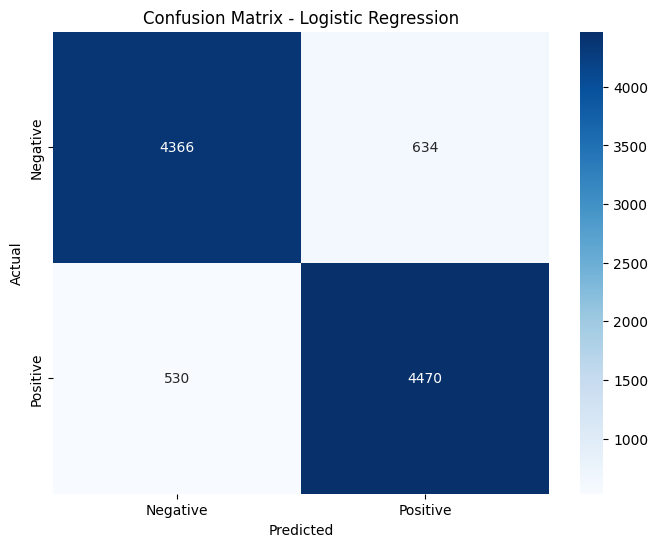


📈 Top 10 Positive Sentiment Features:
 excellent: 6.6513
 great: 6.4907
 perfect: 5.4664
 amazing: 4.9206
 hilarious: 4.4813
 loved: 4.4793
 wonderful: 4.4474
 favorite: 4.2195
 enjoyed: 4.0980
 one best: 4.0865

📉 Top 10 Negative Sentiment Features:
 worst: -9.1144
 awful: -7.8009
 bad: -7.0815
 waste: -6.9986
 boring: -6.0984
 terrible: -5.6157
 poor: -5.5791
 poorly: -5.3804
 dull: -5.3361
 worse: -5.1138


In [14]:
# Select best model (highest test accuracy)
best_model_name = results_df['Test Accuracy'].idxmax()
best_model = trained_models[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 Test Accuracy: {results_df.loc[best_model_name, 'Test Accuracy']:.4f}")

# Detailed evaluation
y_pred = best_model.predict(X_test_tfidf)
y_pred_proba = best_model.predict_proba(X_test_tfidf)

print(f"\n📊 Detailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'])

plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance (for Logistic Regression)
if best_model_name == 'Logistic Regression':
    feature_names = tfidf.get_feature_names_out()
    coefficients = best_model.coef_[0]

    # Top positive features
    top_positive = np.argsort(coefficients)[-10:]
    # Top negative features
    top_negative = np.argsort(coefficients)[:10]

    print("\n📈 Top 10 Positive Sentiment Features:")
    for i in reversed(top_positive):
        print(f" {feature_names[i]}: {coefficients[i]:.4f}")
    print("\n📉 Top 10 Negative Sentiment Features:")
    for i in top_negative:
        print(f" {feature_names[i]}: {coefficients[i]:.4f}")    

In [22]:
# Save the best model and vectorizer
joblib.dump(best_model,rf'C:\Users\admin\Desktop\data\models\best_sentiment_model_{best_model_name.lower().replace(" ","_")}.pkl')
joblib.dump(tfidf, r'C:\Users\admin\Desktop\data\models\tfidf_vectorizer.pkl')

print(f"💾 Model saved:../models/best_sentiment_model_{best_model_name.lower().replace(' ','_')}.pkl")
print(f"💾 Vectorizer saved: ../models/tfidf_vectorizer.pkl")

# Create model info
model_info = {
    'model_type': best_model_name,
    'test_accuracy': results_df.loc[best_model_name, 'Test Accuracy'],
    'cv_mean': results_df.loc[best_model_name, 'CV Mean'],
    'cv_std': results_df.loc[best_model_name, 'CV Std'],
    'features': X_train_tfidf.shape[1],
    'train_time': results_df.loc[best_model_name, 'Train Time (s)']
}


with open(r'C:\Users\admin\Desktop\data\models\model_info.json', 'w') as f:
    json.dump(model_info, f, indent=2)

print("📋 Model info saved successfully!")


💾 Model saved:../models/best_sentiment_model_logistic_regression.pkl
💾 Vectorizer saved: ../models/tfidf_vectorizer.pkl
📋 Model info saved successfully!
